In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.preprocessing import OneHotEncoder

from masterthesis_helper_functions import split_data_forecasting_window_with_validation
from masterthesis_helper_functions import plot_date_range
from masterthesis_helper_functions import evaluate_regression
from masterthesis_helper_functions import plot_actual_vs_predicted_time_series
from masterthesis_helper_functions import plot_actual_vs_predicted
from masterthesis_helper_functions import plot_residuals_vs_predicted
from masterthesis_helper_functions import split_data_random_intervals

In [2]:
if 'Combined_Load_And_TrafoData' not in locals():
    print('Data not in memory')
    print('Loading Combined_Load_And_TrafoData.csv...')
    Combined_Load_And_TrafoData = pd.read_csv('240226_Combined_Load_And_TrafoData.csv', index_col=0, parse_dates=True)
elif 'Combined_Load_And_TrafoData' in locals():
    print('Data already in memory')
    pass

print('Data is now availlable in the variable Combined_Load_And_TrafoData')

Data not in memory
Loading Combined_Load_And_TrafoData.csv...
Data is now availlable in the variable Combined_Load_And_TrafoData


C:\Users\matbi\AppData\Local\Temp\ipykernel_7648\2874138183.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Combined_Load_And_TrafoData = pd.read_csv('240226_Combined_Load_And_TrafoData.csv', index_col=0, parse_dates=True)


In [4]:
df = Combined_Load_And_TrafoData.copy()
# Convert 'datetime' column to datetime type if it's not already
df['datetime'] = pd.to_datetime(df['datetime'])

# Set 'datetime' as the index
df.set_index('datetime', inplace=True)

In [5]:
# Now, generate intervals with random lengths between 4 and 14 days
# Determine the range of the dataset
start_date = df.index.min()
end_date = df.index.max()
random_intervals = split_data_random_intervals(df, start_date, end_date, 4, 14, seed = 4711)

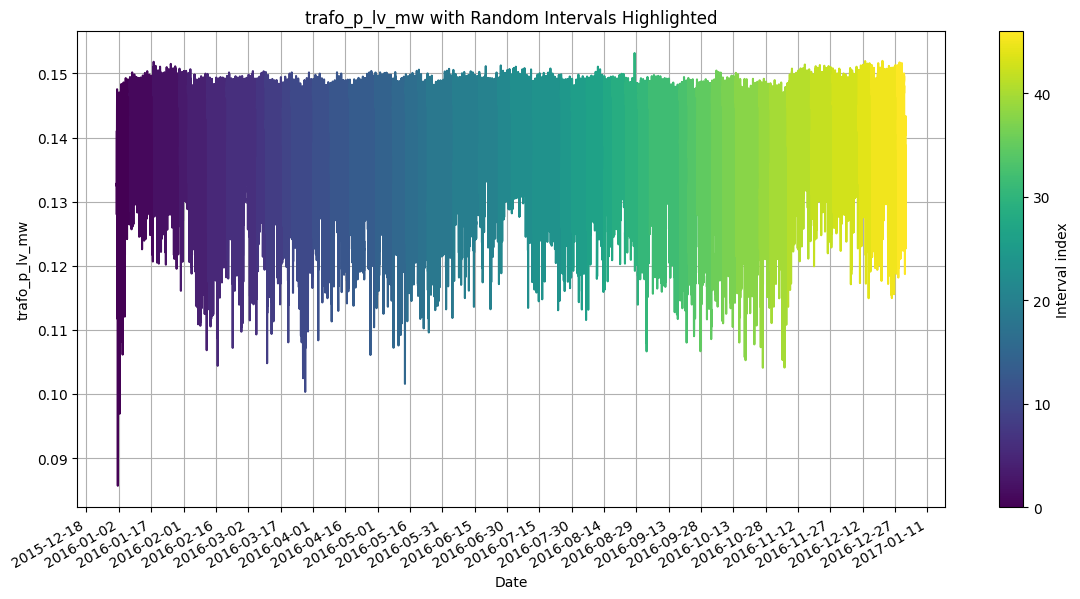

In [6]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(14, 7))

# Create a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(random_intervals)))

# Plot each interval in a different color
for interval, color in zip(random_intervals, colors):
    ax.plot(interval.index, interval['trafo_p_lv_mw'], color=color)

# Set the title and labels
ax.set_title('trafo_p_lv_mw with Random Intervals Highlighted')
ax.set_xlabel('Date')
ax.set_ylabel('trafo_p_lv_mw')

# Set the format of the dates on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
fig.autofmt_xdate()  # Rotate date labels to prevent overlap
ax.grid(True)

# Create a ScalarMappable and use it for the colorbar
norm = plt.Normalize(vmin=0, vmax=len(random_intervals))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # This line is necessary for ScalarMappable
plt.colorbar(sm, ax=ax, label='Interval index')  # Link the colorbar to the created axes

plt.show()

In [7]:
# Make random intervals a pd dataframe and add a column with the interval index
random_intervals_df = pd.concat(random_intervals)
random_intervals_df['interval_index'] = np.concatenate([np.repeat(i, len(interval)) for i, interval in enumerate(random_intervals)]) 
random_intervals_df.reset_index(inplace=True)
random_intervals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35181 entries, 0 to 35180
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   datetime               35181 non-null  datetime64[ns]
 1   trafo_p_hv_mw          35181 non-null  float64       
 2   trafo_q_hv_mvar        35181 non-null  float64       
 3   trafo_p_lv_mw          35181 non-null  float64       
 4   trafo_q_lv_mvar        35181 non-null  float64       
 5   trafo_pl_mw            35181 non-null  float64       
 6   trafo_ql_mvar          35181 non-null  float64       
 7   trafo_i_hv_ka          35181 non-null  float64       
 8   trafo_i_lv_ka          35181 non-null  float64       
 9   trafo_vm_hv_pu         35181 non-null  float64       
 10  trafo_va_hv_degree     35181 non-null  float64       
 11  trafo_vm_lv_pu         35181 non-null  float64       
 12  trafo_va_lv_degree     35181 non-null  float64       
 13  t

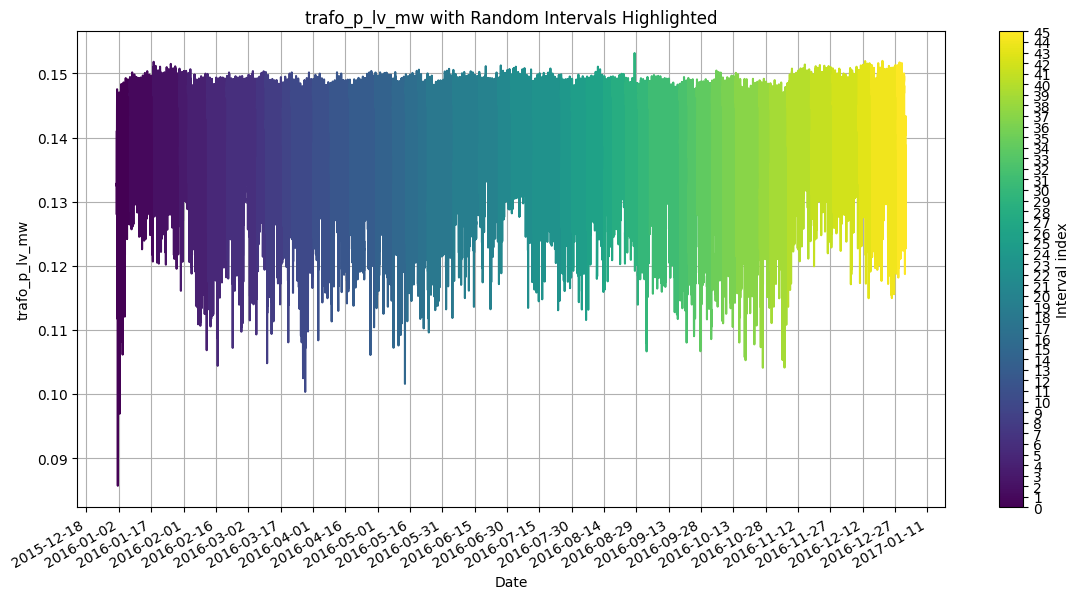

In [8]:
# Check if the intervals are correct

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(14, 7))

# Define the number of intervals for color mapping
num_intervals = random_intervals_df['interval_index'].nunique()

# Create a list of colors, one for each interval
colors = plt.cm.viridis(np.linspace(0, 1, num_intervals))

# Plot using the DataFrame, coloring by 'interval_index'
for i in range(num_intervals):
    # Select data for the current interval
    interval_data = random_intervals_df[random_intervals_df['interval_index'] == i]
    # Plot the data
    ax.plot(interval_data['datetime'], interval_data['trafo_p_lv_mw'], color=colors[i])

# Set the title and labels
ax.set_title('trafo_p_lv_mw with Random Intervals Highlighted')
ax.set_xlabel('Date')
ax.set_ylabel('trafo_p_lv_mw')

# Set the format of the dates on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Adjust the interval for better readability if necessary
fig.autofmt_xdate()  # Rotate date labels to prevent overlap
ax.grid(True)

# Create a ScalarMappable for the colorbar
norm = plt.Normalize(vmin=0, vmax=num_intervals - 1)  # Normalizing for the number of intervals
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Set the array to an empty list
plt.colorbar(sm, ax=ax, label='Interval index', ticks=range(num_intervals))  # Link the colorbar to the axes

plt.show()

# Sinus Transform the data

In [9]:
random_intervals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35181 entries, 0 to 35180
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   datetime               35181 non-null  datetime64[ns]
 1   trafo_p_hv_mw          35181 non-null  float64       
 2   trafo_q_hv_mvar        35181 non-null  float64       
 3   trafo_p_lv_mw          35181 non-null  float64       
 4   trafo_q_lv_mvar        35181 non-null  float64       
 5   trafo_pl_mw            35181 non-null  float64       
 6   trafo_ql_mvar          35181 non-null  float64       
 7   trafo_i_hv_ka          35181 non-null  float64       
 8   trafo_i_lv_ka          35181 non-null  float64       
 9   trafo_vm_hv_pu         35181 non-null  float64       
 10  trafo_va_hv_degree     35181 non-null  float64       
 11  trafo_vm_lv_pu         35181 non-null  float64       
 12  trafo_va_lv_degree     35181 non-null  float64       
 13  t

In [10]:
# Remove year, quarter, month, day, hour, day_of_week, columns to be shure that it is correct
random_intervals_df.drop(['year', 'quarter', 'month', 'day', 'hour', 'day_of_week'], axis=1, inplace=True)

In [11]:
# Extracting time-related features
random_intervals_df['hour_of_day'] = random_intervals_df['datetime'].dt.hour
random_intervals_df['day_of_week'] = random_intervals_df['datetime'].dt.weekday
random_intervals_df['month_of_year'] = random_intervals_df['datetime'].dt.month - 1  # Zero-indexing month

In [12]:
# Sine transformation
random_intervals_df['sin_hour_of_day'] = np.sin(2 * np.pi * random_intervals_df['hour_of_day'] / 24)
random_intervals_df['sin_day_of_week'] = np.sin(2 * np.pi * random_intervals_df['day_of_week'] / 7)
random_intervals_df['sin_month_of_year'] = np.sin(2 * np.pi * random_intervals_df['month_of_year'] / 12)

In [13]:
# Display the new dataframe with the sine-transformed features
print(random_intervals_df[['sin_hour_of_day', 'sin_day_of_week', 'sin_month_of_year']])

       sin_hour_of_day  sin_day_of_week  sin_month_of_year
0             0.000000        -0.433884                0.0
1             0.000000        -0.433884                0.0
2             0.000000        -0.433884                0.0
3             0.000000        -0.433884                0.0
4             0.258819        -0.433884                0.0
...                ...              ...                ...
35176        -0.500000        -0.974928               -0.5
35177        -0.258819        -0.974928               -0.5
35178        -0.258819        -0.974928               -0.5
35179        -0.258819        -0.974928               -0.5
35180        -0.258819        -0.974928               -0.5

[35181 rows x 3 columns]


In [14]:
# Assuming start_date is already defined
# Make sure start_date is a datetime object
if not isinstance(start_date, pd.Timestamp):
    start_date = pd.to_datetime(start_date)

# Define end dates for each plot based on the start_date
end_date_week = start_date + pd.Timedelta(weeks=2)
end_date_month = start_date + pd.Timedelta(days=60)  # Approximation for two month
end_date_year = start_date + pd.Timedelta(days=365)

# Filter the DataFrame for each plot
week_data = random_intervals_df[(random_intervals_df['datetime'] >= start_date) & (random_intervals_df['datetime'] < end_date_week)]
month_data = random_intervals_df[(random_intervals_df['datetime'] >= start_date) & (random_intervals_df['datetime'] < end_date_month)]
year_data = random_intervals_df[(random_intervals_df['datetime'] >= start_date) & (random_intervals_df['datetime'] < end_date_year)]

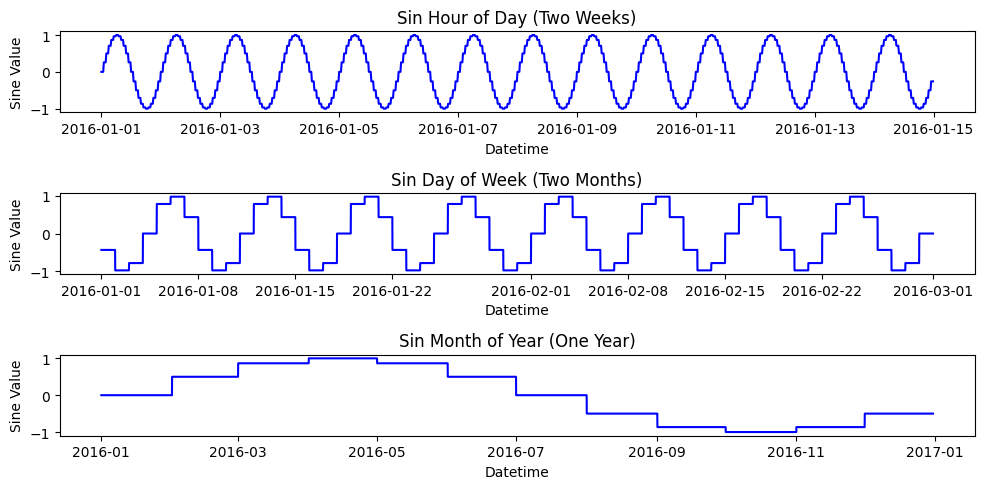

In [15]:
# Plotting
plt.figure(figsize=[10, 5])  # Adjust for vertical stacking

# sin_hour_of_day for one week
plt.subplot(3, 1, 1)  # 3 rows, 1 column, first plot
plt.plot(week_data['datetime'], week_data['sin_hour_of_day'], color='blue')
plt.title('Sin Hour of Day (Two Weeks)')
plt.xlabel('Datetime')
plt.ylabel('Sine Value')

# sin_day_of_week for one month
plt.subplot(3, 1, 2)  # 3 rows, 1 column, second plot
plt.plot(month_data['datetime'], month_data['sin_day_of_week'], color='blue')
plt.title('Sin Day of Week (Two Months)')
plt.xlabel('Datetime')
plt.ylabel('Sine Value')

# sin_month_of_year for one year
plt.subplot(3, 1, 3)  # 3 rows, 1 column, third plot
plt.plot(year_data['datetime'], year_data['sin_month_of_year'], color='blue')
plt.title('Sin Month of Year (One Year)')
plt.xlabel('Datetime')
plt.ylabel('Sine Value')

plt.tight_layout()
plt.show()

# One Hot Encoding

In [16]:
# One hot encoding
# Select columns to one-hot encode
columns_to_encode = ['is_weekend']

# Create the encoder instance. Note that 'drop' parameter is optional.
encoder = OneHotEncoder(drop='first')  # Use drop=None if you don't want to drop the first category.

# Fit and transform the selected data and convert it into a DataFrame
encoded_data = encoder.fit_transform(random_intervals_df[columns_to_encode])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(columns_to_encode))

# Ensure the original DataFrame index aligns with the encoded data
random_intervals_df.reset_index(drop=True, inplace=True)  # Reset index if necessary

# Join the encoded data with the original DataFrame
df_encoded = pd.concat([random_intervals_df, encoded_df], axis=1)

# Drop the original columns as they are now encoded
df_encoded.drop(columns_to_encode, axis=1, inplace=True)

In [17]:
df_encoded

,datetime,trafo_p_hv_mw,trafo_q_hv_mvar,trafo_p_lv_mw,trafo_q_lv_mvar,trafo_pl_mw,trafo_ql_mvar,trafo_i_hv_ka,trafo_i_lv_ka,trafo_vm_hv_pu,...,sgen_p_LV1.101 Bus 8,sgen_p_LV1.101 Bus 13,interval_index,hour_of_day,day_of_week,month_of_year,sin_hour_of_day,sin_day_of_week,sin_month_of_year,is_weekend_1
0,2016-01-01 00:00:00,-0.138606,0.036278,0.140890,-0.031716,0.002285,0.004562,0.004035,0.202417,1.025,...,0.0,0.0,0,0,4,0,0.000000,-0.433884,0.0,0.0
1,2016-01-01 00:15:00,-0.130922,0.035803,0.133022,-0.031707,0.002100,0.004096,0.003823,0.191789,1.025,...,0.0,0.0,0,0,4,0,0.000000,-0.433884,0.0,0.0
2,2016-01-01 00:30:00,-0.126639,0.035554,0.128641,-0.031707,0.002002,0.003847,0.003704,0.185882,1.025,...,0.0,0.0,0,0,4,0,0.000000,-0.433884,0.0,0.0
3,2016-01-01 00:45:00,-0.126705,0.035556,0.128708,-0.031706,0.002003,0.003851,0.003706,0.185972,1.025,...,0.0,0.0,0,0,4,0,0.000000,-0.433884,0.0,0.0
4,2016-01-01 01:00:00,-0.126007,0.035517,0.127994,-0.031706,0.001988,0.003811,0.003687,0.185010,1.025,...,0.0,0.0,0,1,4,0,0.258819,-0.433884,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35176,2016-12-31 22:45:00,-0.132632,0.035913,0.134772,-0.031716,0.002141,0.004197,0.003870,0.194154,1.025,...,0.0,0.0,45,22,5,11,-0.500000,-0.974928,-0.5,1.0
35177,2016-12-31 23:00:00,-0.134373,0.036018,0.136555,-0.031716,0.002182,0.004302,0.003918,0.196560,1.025,...,0.0,0.0,45,23,5,11,-0.258819,-0.974928,-0.5,1.0
35178,2016-12-31 23:15:00,-0.140982,0.036430,0.143326,-0.031718,0.002344,0.004712,0.004101,0.205710,1.025,...,0.0,0.0,45,23,5,11,-0.258819,-0.974928,-0.5,1.0
35179,2016-12-31 23:30:00,-0.138504,0.036273,0.140786,-0.031717,0.002282,0.004556,0.004032,0.202276,1.025,...,0.0,0.0,45,23,5,11,-0.258819,-0.974928,-0.5,1.0


In [18]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35181 entries, 0 to 35180
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   datetime               35181 non-null  datetime64[ns]
 1   trafo_p_hv_mw          35181 non-null  float64       
 2   trafo_q_hv_mvar        35181 non-null  float64       
 3   trafo_p_lv_mw          35181 non-null  float64       
 4   trafo_q_lv_mvar        35181 non-null  float64       
 5   trafo_pl_mw            35181 non-null  float64       
 6   trafo_ql_mvar          35181 non-null  float64       
 7   trafo_i_hv_ka          35181 non-null  float64       
 8   trafo_i_lv_ka          35181 non-null  float64       
 9   trafo_vm_hv_pu         35181 non-null  float64       
 10  trafo_va_hv_degree     35181 non-null  float64       
 11  trafo_vm_lv_pu         35181 non-null  float64       
 12  trafo_va_lv_degree     35181 non-null  float64       
 13  t

# Create Dataset


In [19]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test datasets using a 70-15-15 split
train, test = train_test_split(df_encoded, test_size=0.3, random_state=4711)
validation, test = train_test_split(test, test_size=0.5, random_state=4711)

# Check the length of each dataset
print(f'Training data length: {len(train)}')
print(f'Validation data length: {len(validation)}')
print(f'Test data length: {len(test)}')


Training data length: 24626
Validation data length: 5277
Test data length: 5278


In [20]:
def resample_dataset(dataset, datetime_column, frequency):
    # Convert the datetime column to datetime objects
    dataset[datetime_column] = pd.to_datetime(dataset[datetime_column])
    # Set the datetime column as the index
    dataset = dataset.set_index(datetime_column)
    # Resample and return the dataset
    if frequency == 'T':
        frequency = 'min'
    elif frequency == 'H':
        frequency = 'h'
    return dataset.resample(frequency).mean()


In [21]:
df_15min = resample_dataset(df_encoded, 'datetime', '15min')
df_1h = resample_dataset(df_encoded, 'datetime', '1h')
df_6h = resample_dataset(df_encoded, 'datetime', '6h')
df_1d = resample_dataset(df_encoded, 'datetime', '1d')  # Or '24h' for daily

In [22]:
def split_data(data, train_size=0.7, val_size=0.15, test_size=0.15):
    n = len(data)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))
    train = data[:train_end]
    validate = data[train_end:val_end]
    test = data[val_end:]
    return train, validate, test

# Apply the split to each dataset
train_15min, validate_15min, test_15min = split_data(df_15min)
train_1h, validate_1h, test_1h = split_data(df_1h)
train_6h, validate_6h, test_6h = split_data(df_6h)
train_1d, validate_1d, test_1d = split_data(df_1d)

In [23]:
def plot_data_splits(original_df, train, validate, test, title='Data Split'):
    plt.figure(figsize=(15, 6))  # Set the figure size for better readability
    plt.plot(original_df.index, original_df['trafo_p_hv_mw'], label='Original', alpha=0.5)  # Adjust 'your_main_column' to your primary data column
    plt.plot(train.index, train['trafo_p_hv_mw'], label='Train')
    plt.plot(validate.index, validate['trafo_p_hv_mw'], label='Validate')
    plt.plot(test.index, test['trafo_p_hv_mw'], label='Test')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


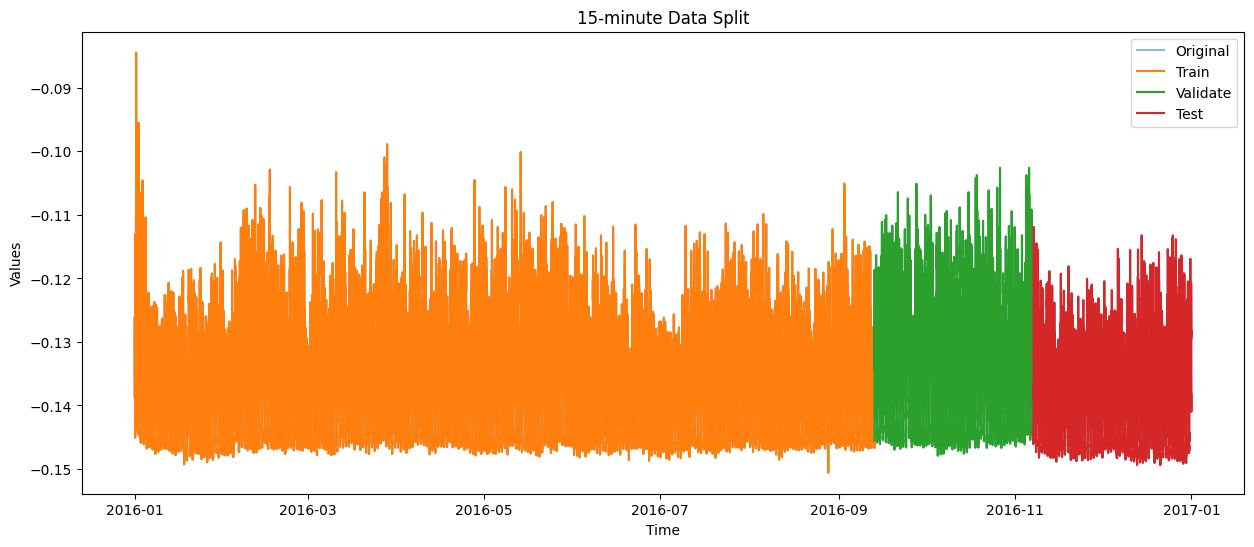

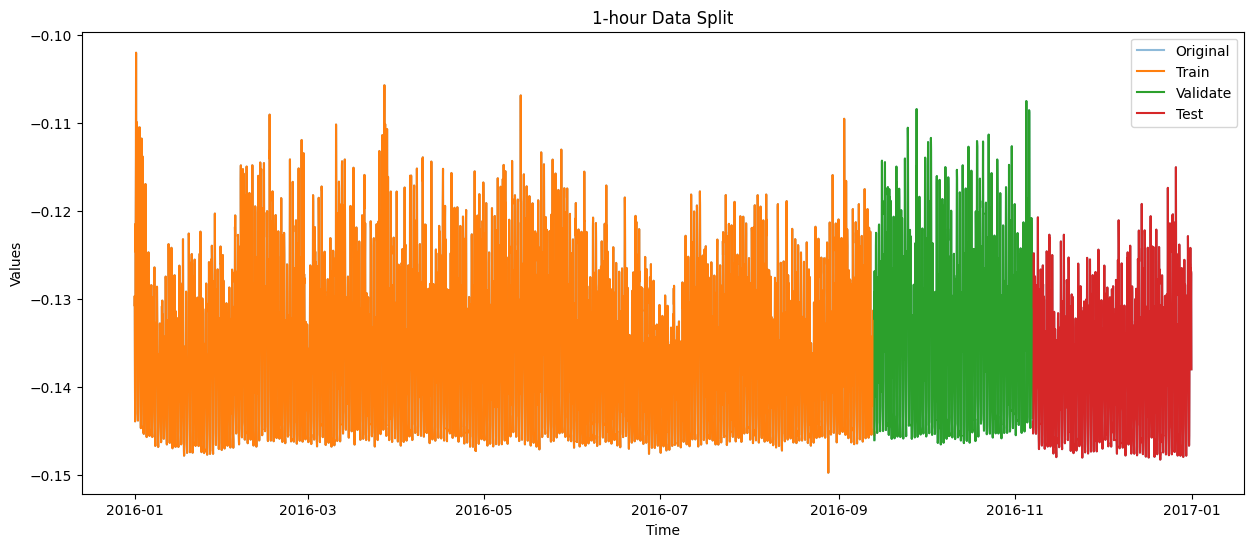

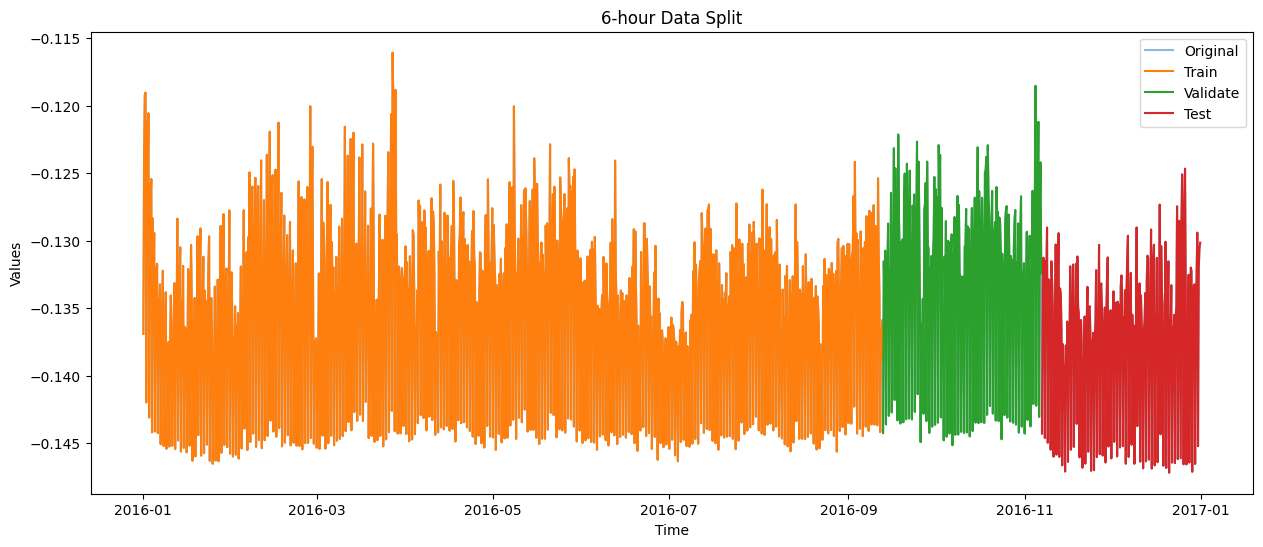

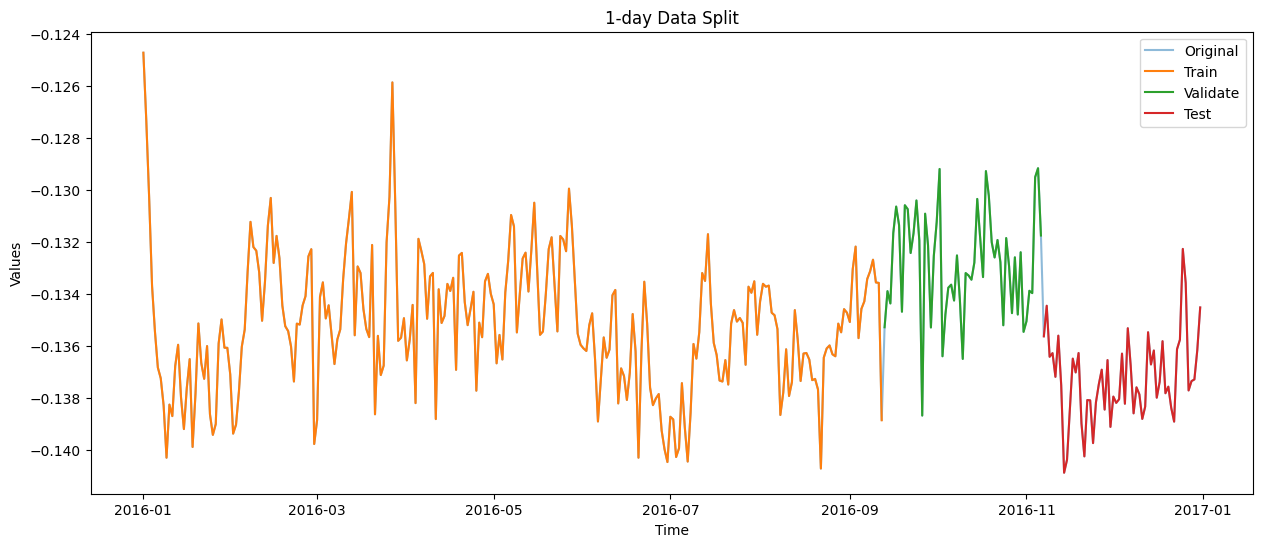

In [24]:
# Plot for 15-minute data
plot_data_splits(df_15min, train_15min, validate_15min, test_15min, title='15-minute Data Split')

# Plot for 1-hour data
plot_data_splits(df_1h, train_1h, validate_1h, test_1h, title='1-hour Data Split')

# Plot for 6-hour data
plot_data_splits(df_6h, train_6h, validate_6h, test_6h, title='6-hour Data Split')

# Plot for 1-day data
plot_data_splits(df_1d, train_1d, validate_1d, test_1d, title='1-day Data Split')


In [25]:
# Show length of each dataset
print(f'15-minute data length: {len(df_15min)}')
print(f'15-minute training data length: {len(train_15min)}')
print(f'15-minute validation data length: {len(validate_15min)}')
print(f'15-minute test data length: {len(test_15min)}')
print()
print(f'1-hour data length: {len(df_1h)}')
print(f'1-hour training data length: {len(train_1h)}')
print(f'1-hour validation data length: {len(validate_1h)}')
print(f'1-hour test data length: {len(test_1h)}')
print()
print(f'6-hour data length: {len(df_6h)}')
print(f'6-hour training data length: {len(train_6h)}')
print(f'6-hour validation data length: {len(validate_6h)}')
print(f'6-hour test data length: {len(test_6h)}')
print()
print(f'1-day data length: {len(df_1d)}')
print(f'1-day training data length: {len(train_1d)}')
print(f'1-day validation data length: {len(validate_1d)}')
print(f'1-day test data length: {len(test_1d)}')
# Show length of each dataset


15-minute data length: 35136
15-minute training data length: 24595
15-minute validation data length: 5270
15-minute test data length: 5271

1-hour data length: 8784
1-hour training data length: 6148
1-hour validation data length: 1318
1-hour test data length: 1318

6-hour data length: 1464
6-hour training data length: 1024
6-hour validation data length: 220
6-hour test data length: 220

1-day data length: 366
1-day training data length: 256
1-day validation data length: 55
1-day test data length: 55


In [26]:
# Save each df_ file to a csv file in a new folder called 'rural1_s1'
# create folder
import os
if not os.path.exists('rural1_s1'):
    os.makedirs('rural1_s1')

# Save each df_ file to a csv file
df_15min.to_csv('rural1_s1/df_15min.csv')
df_1h.to_csv('rural1_s1/df_1h.csv')
df_6h.to_csv('rural1_s1/df_6h.csv')
df_1d.to_csv('rural1_s1/df_1d.csv')

# Save each train_ file to a csv file
train_15min.to_csv('rural1_s1/train_15min.csv')
train_1h.to_csv('rural1_s1/train_1h.csv')
train_6h.to_csv('rural1_s1/train_6h.csv')
train_1d.to_csv('rural1_s1/train_1d.csv')

# Save each validate_ file to a csv file
validate_15min.to_csv('rural1_s1/validate_15min.csv')
validate_1h.to_csv('rural1_s1/validate_1h.csv')
validate_6h.to_csv('rural1_s1/validate_6h.csv')
validate_1d.to_csv('rural1_s1/validate_1d.csv')

# Save each test_ file to a csv file
test_15min.to_csv('rural1_s1/test_15min.csv')
test_1h.to_csv('rural1_s1/test_1h.csv')
test_6h.to_csv('rural1_s1/test_6h.csv')
test_1d.to_csv('rural1_s1/test_1d.csv')

